# Lab3.7 Testing classifiers on a different data set with tweets

Copyright: Vrije Universiteit Amsterdam, Faculty of Humanities, CLTL

The data set that we are going to use is from an NLP task on emotion detection that was organised in the *Wassa* workshop in 2017. The texts are tweets and therefore a different genre than the spoken utterances from the conversations in the MELD data set:

http://saifmohammad.com/WebPages/EmotionIntensity-SharedTask.html

We included the data set in the distribution of this lab and aggregated all the training data in a single file that we now can load using *Pandas*.

### 1. Loading the tweet data set

In [2]:
import pandas as pd
filepath = './data/wassa/training/all.train.tsv'
dftweets_train = pd.read_csv(filepath, sep='\t')
dftweets_train.head()


,ID,Tweet,Label,Score
0,10000,How the fu*k! Who the heck! moved my fridge!.....,anger,0.938
1,10001,So my Indian Uber driver just called someone t...,anger,0.896
2,10002,@DPD_UK I asked for my parcel to be delivered ...,anger,0.896
3,10003,so ef whichever butt wipe pulled the fire alar...,anger,0.896
4,10004,Don't join @BTCare they put the phone down on ...,anger,0.896


In [3]:
dftweets_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3613 entries, 0 to 3612
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      3613 non-null   int64  
 1   Tweet   3613 non-null   object 
 2   Label   3613 non-null   object 
 3   Score   3613 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 113.0+ KB


We see that this data set has 3613 tweets, labels and a score. Lets check the distribution of the labels:

<AxesSubplot:>

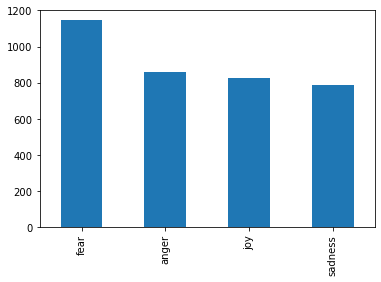

In [4]:
dftweets_train.Label.value_counts().sort_values(ascending=False).plot(kind='bar')

<AxesSubplot:>

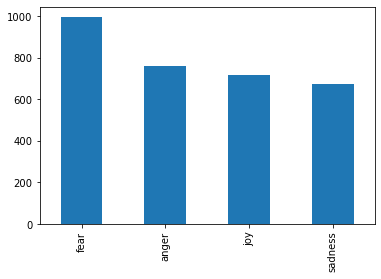

In [5]:
##### Test data
filepath = './data/wassa/testing/all.test.tsv'
dftweets_test = pd.read_csv(filepath, sep='\t')
dftweets_test.Label.value_counts().sort_values(ascending=False).plot(kind='bar')

We see that this data set is more evenly distributed and there are no neutral tweets. Also lacking are *disgust* and *surprise*.

Lets train classifiers as we did before and see what happens. We first extract the tweets and labels using a similar loop as in the previous notebook Lab3.6.

In [11]:
tweet_train_instances=[]
tweet_train_labels = []
for tweet in dftweets_train['Tweet']:
    ### We break the loop after 2000 instances 
    #if index==2000:
    #    break
    tweet_train_instances.append(tweet)


for label in dftweets_train['Label']:
    ### We break the loop after 2000 instances 
    #if index==2000:
    #    break    ### we need to surround the next statements with 'try' and 'except' to catch cases 
    tweet_train_labels.append(label)

print('Number of training instances', len(tweet_train_instances))
print('Number of training labels', len(tweet_train_labels))

Number of training instances 3613
Number of training labels 3613


In [12]:
tweet_test_instances=[]
tweet_test_labels = []
for tweet in dftweets_test['Tweet']:
    ### We break the loop after 2000 instances 
    #if index==2000:
    #    break
    tweet_test_instances.append(tweet)


for label in dftweets_test['Label']:
    ### We break the loop after 2000 instances 
    #if index==2000:
    #    break    ### we need to surround the next statements with 'try' and 'except' to catch cases 
    tweet_test_labels.append(label)

print('Test instances', len(tweet_test_instances))
print('Test labels', len(tweet_test_labels))

Test instances 3142
Test labels 3142


### 2. Representing and classifying the tweets as averaged word embeddings

#### 2.1 Representing the tweet training data using the same word embeddings

We can use the same functions that we used in the notebook *Lab3.6.ml.emotion-detection.embeddings.ipynb* to get averaged embeddings for the tweets. 
In order to use exactly the same function and to be able to re-use them again, we copied the function to a separate python file "lab3_util.py". You can open the file in Jupyter to inspect its content.

We can now import this file as we do with other packages and apply it in this notebook but also in other code. This keeps our notebook readable and compact and makes sure we always use the same functions and do not accidently change them across notebooks.

For future coding, it is wise to also apply this to your own code. Put reusable code as functions in a separate Python file with an illegible name and import this in different notebooks or other Python files. In this way, you develop your own tools over time and reuse them when needed.

We first import the Python file *lab3_util.py* in this notebook so that the functions are loaded in working memory. The file should be located in the same folder as this notebook.

In [7]:
import lab3_util as util

We also import the other 3rd party packages as we did before.

In [13]:
import sklearn
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import nltk
from nltk.corpus import stopwords

ModuleNotFoundError: No module named 'sklearn'

We also need to load the same word embedding model as we used before to get compatible word embeddings for this data. Choose whatever you used before.

In [18]:
import gensim
from gensim.models.word2vec import Word2Vec
import gensim.downloader as api
# download the model and return as object ready for use
wordembeddings="glove-twitter-25"
word_embedding_model = api.load(wordembeddings)
num_features = 25

We can now directly call the functions defined in *lab3_utility.py* through the instantiation *util*, e.g. "util.getMostFrequentWords".

In [11]:
#### We turn the word2vec wordindex into a set for efficiency
index2word_set = set(word_embedding_model.wv.index2word)
stop_words = set(stopwords.words('english'))

 #### We use two word list to keep track of the words that are also in the embedding model and words that are not

known_words = []  # utterance words that are also in the embedding model
unknown_words =[] # utterance words that are not in the mebedding model

frequency_threshold=4

#Here we call a function defined in lab3_util.py!!
keywords = util.getMostFrequentWords(frequency_threshold, tweet_train_instances)

tweet_tokens = []
for tweet in tweet_train_instances:
    tweet_tokens.append(nltk.tokenize.word_tokenize(tweet))
    
#Again a function from lab3_util.py
trainDataVecs, known_words, unknown_words = util.getAvgFeatureVecs(tweet_tokens, 
                                                                             keywords, 
                                                                             stop_words, 
                                                                             word_embedding_model, 
                                                                             index2word_set, 
                                                                             num_features)

/Users/piek/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


Nr of words above the frequency threshold 1447
Frequency threshold 4
Shape of our matrix is: (3613, 25)
Review 0 of 3613
Review 1000 of 3613
Review 2000 of 3613
Review 3000 of 3613


As before, we check which words are not in the embedding model's vocabulary.

In [12]:
from collections import Counter

if len(unknown_words)>0:
    unknown_words_count = Counter(unknown_words)
    print('Number of unknown word types',len(unknown_words_count))
    print('Number of unknown word tokens:', len(unknown_words))
    print('Unknown words counts')
    print(unknown_words_count)
    print('Proportion of unknown tokens', len(unknown_words)/(len(unknown_words)+len(known_words)))


known_words_count = Counter(known_words)
print('Number of known word types:',len(known_words_count))
print('Number of known word tokens:', len(known_words))
#print(known_words_count)
    

Number of unknown word types 47
Number of unknown word tokens: 870
Unknown words counts
Counter({'...': 275, '2': 59, 'live.ly': 54, '3': 38, '\\n': 29, '😂': 24, '4': 21, 'realdonaldtrump': 21, '..': 21, '\\n\\n': 18, 'bb18': 16, '1': 16, 'hillaryclinton': 16, '15': 14, '10': 13, '🙄': 13, '5': 11, '6': 11, '2016': 10, "y'all": 10, '😭': 10, '20': 10, '😂😂': 9, '7': 9, '😕': 8, '100': 8, '❤️': 8, '😡': 7, 'w/': 7, '12': 7, '8': 7, '70': 7, 'charlotteprotest': 6, '😩': 6, '3rd': 6, 'mhchat': 6, '😢': 6, '😳': 6, 'wch2016': 6, 'thenicebot': 6, '🤗': 5, '🙃': 5, '17': 5, '😂😂😂': 5, '2day': 5, '😅': 5, '48': 5})
Proportion of unknown tokens 0.024041782960731756
Number of known word types: 1205
Number of known word tokens: 35317


We clearly see that emoticons are not in the vocabulary of the embedding model. Most words are however covered. Discuss in your group how you could fix this and report in class.

### 2.2 Representing the tweet test data through embeddings

In [13]:

tweet_tokens = []
for tweet in tweet_test_instances:
    tweet_tokens.append(nltk.tokenize.word_tokenize(tweet))

testDataVecs, known_words, unknown_words = util.getAvgFeatureVecs(tweet_tokens, 
                                                                             keywords, 
                                                                             stop_words, 
                                                                             word_embedding_model, 
                                                                             index2word_set, 
                                                                             num_features)




Shape of our matrix is: (3142, 25)
Review 0 of 3142
Review 1000 of 3142
Review 2000 of 3142
Review 3000 of 3142


In [14]:
if len(unknown_words)>0:
    unknown_words_count = Counter(unknown_words)
    print('Number of unknown word types',len(unknown_words_count))
    print('Number of unknown word tokens:', len(unknown_words))
    print('Unknown words counts')
    print(unknown_words_count)
    print('Proportion of unknown tokens', len(unknown_words)/(len(unknown_words)+len(known_words)))


known_words_count = Counter(known_words)
print('Number of known word types:',len(known_words_count))
print('Number of known word tokens:', len(known_words))
#print(known_words_count)

Number of unknown word types 45
Number of unknown word tokens: 748
Unknown words counts
Counter({'...': 301, '2': 67, '😂': 32, '3': 26, '1': 23, '\\n': 22, '4': 20, 'bb18': 17, '6': 16, '20': 14, '..': 13, '5': 13, 'realdonaldtrump': 12, 'hillaryclinton': 12, '10': 11, "y'all": 10, '15': 10, 'mhchat': 10, '7': 9, '😂😂': 9, '🙃': 7, '100': 7, '😩': 7, '😭': 7, '\\n\\n': 7, '12': 7, '2016': 6, '😅': 5, '🙄': 5, '😳': 5, 'w/': 4, '17': 4, '8': 3, '😡': 3, '😢': 3, '❤️': 3, 'charlotteprotest': 3, '😕': 3, '3rd': 3, '😂😂😂': 2, '48': 2, 'thenicebot': 2, 'live.ly': 1, 'wch2016': 1, '70': 1})
Proportion of unknown tokens 0.02481340189086084
Number of known word types: 1139
Number of known word tokens: 29397


The unknown words list is a good sanity check. You need to know what you are dealing with and if there are no unexpected differences between train and test. All seems good in this case. Similar words are listed in the top frequencies.

Next, we could to convert the labels to the same numeric valus that we used before with our LabelEncoder. However, the set of labels is not the same and, if we do it, we want to keep the numeric mapping the same for those that map. The next code does this, but you can also skip this and use the string labels while eye balling the results across the notebooks.


In [27]:
from sklearn import preprocessing
# first we instantiate a label encode
le = preprocessing.LabelEncoder()
# we feed this encoder with the complete list of labels from our data
labels = ['fear', 'anger', 'joy',  'sadness']
le.fit(labels)
print(list(le.classes_))
tweet_train_classes = le.transform(tweet_train_labels)
tweet_test_classes = le.transform(tweet_test_labels)

print(list(tweet_train_classes[-10:]))

['anger', 'fear', 'joy', 'sadness']
[3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


We see that the first set of tweets are all expressing *anger* (idex '0') which makes sense given the way the data were concatenated from the separate files with tweets. Let's check the last 10 tweets, which should score for *sadness*:

In [28]:
print(list(tweet_train_classes[-10:]))

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


### 2.3 Training and testing the classifier

In [29]:
from sklearn import svm
from sklearn.metrics import classification_report

# We choose a Linear model
svm_linear_clf = svm.LinearSVC(max_iter=2000)
### we train the classifier through the *fit* function and by passing the training vectors and the training labels as paramters:
svm_linear_clf.fit(trainDataVecs, tweet_train_classes)

# Predicting the Test set results, find macro recall
y_pred_svm_linear = svm_linear_clf.predict(testDataVecs)

#### this report gives the results for the LINEAR classifier
report = classification_report(tweet_test_classes,y_pred_svm_linear,digits = 7)
print(le.classes_)
print('Tweet Embeddings SVM LINEAR ----------------------------------------------------------------')
print('Word embedding model used', wordembeddings)
print('Word frequency threshold', frequency_threshold)
print(report)

['anger' 'fear' 'joy' 'sadness']
Tweet Embeddings SVM LINEAR ----------------------------------------------------------------
Word embedding model used glove-twitter-25
Word frequency threshold 4
              precision    recall  f1-score   support

           0  0.4760077 0.3263158 0.3871975       760
           1  0.4489281 0.7155779 0.5517241       995
           2  0.5636605 0.5952381 0.5790191       714
           3  0.4590747 0.1916790 0.2704403       673

    accuracy                      0.4818587      3142
   macro avg  0.4869178 0.4572027 0.4470952      3142
weighted avg  0.4837238 0.4818587 0.4578808      3142



As we can see, we only have test results for the 4 classes because there are no tweet data for the others. The results are not that bad.

## 3 Testing the MELD classifiers on the tweets test set

We have now trained and tested an emotion classifier on tweet data. What about the MELD classifiers that we built before and saved to disk? Can we load these and test them on the same test tweet data set?

With embeddings this is easy because the representations are independent of the words but we need to use the same embedding model for both the training and testing. So if we used the *glove_twitter* embeddings for MELD with 25 dimensions, we have to do the same for the tweet test data.

For the BoW classifiers, we need to use CountVectorizer and the *transform_fit* function to model the test data accordingly.

If you saved the MELD models using the previous notebook, you can load the models now again. Otherwise, you need to rebuilt them, save them and next load them here.

#### 3.2 Loading the MELD classifier for embedding representations

In [30]:
import pickle
filename_classifier = './models/svm_linear_clf_embeddings.sav'

# load the classifier and the vectorizer from disk
svm_linear_clf = pickle.load(open(filename_classifier, 'rb'))

Because the vector representations for MELD and the test tweets were created using the same function and through the same embedding model we can now use it directly to classify the tweet test data we just created in the previous section.

In [31]:
# have classifier make a prediction
tweet_pred_linear_embeddings = svm_linear_clf.predict(testDataVecs)
report = classification_report(tweet_test_classes,tweet_pred_linear_embeddings,digits = 7)
print(le.classes_)
print('SVM NONLINEAR EMBEDDINGS ----------------------------------------------------------------')
print(report)

['anger' 'fear' 'joy' 'sadness']
SVM NONLINEAR EMBEDDINGS ----------------------------------------------------------------
              precision    recall  f1-score   support

           0  0.4561404 0.0342105 0.0636475       760
           1  0.0000000 0.0000000 0.0000000       995
           2  0.0000000 0.0000000 0.0000000       714
           3  0.2063492 0.2511144 0.2265416       673
           4  0.0000000 0.0000000 0.0000000         0
           5  0.0000000 0.0000000 0.0000000         0
           6  0.0000000 0.0000000 0.0000000         0

    accuracy                      0.0620624      3142
   macro avg  0.0946414 0.0407607 0.0414556      3142
weighted avg  0.1545320 0.0620624 0.0639193      3142



/Users/piek/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/piek/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Because the tweets data is different from MELD, we see that there is no support for *disgust*, *neutral*, and *surprise*. These are not in the data set.
There is data for *fear* and *joy* but the results are bad with zero recall and zero precision. This clearly shows you cannot easily deploy a classifier to other types and domains of text.

### 3. Representing and classifying the tweets as a bag-of-words vector

#### 3.1 Representing the tweets as BoW vectors

In order to represent the test tweets according to our BoW vector representation derived from the MELD data, we need to load the *utterance_vec* file that we saved before.

In [32]:
# load the classifier and the vectorizer from disk
filename_vectorizer = './models/utterance_vec.sav'
loaded_vectorizer = pickle.load(open(filename_vectorizer, 'rb'))

We can now apply the transform function to the tokenized tweets.

In [33]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

#tfidf_transformer = TfidfTransformer()
#utterance_tfidf = tfidf_transformer.fit_transform(utterance_counts)
tweet_vectors = loaded_vectorizer.transform(tweet_test_instances)
tweet_vectors.shape

(3142, 1217)

We can see that the matrix has vectors of the same size as before for the BoW token vectors.

We can now load the classifier and make the predictions on this data.

In [34]:
# the classifier on disk
filename_classifier = './models/svm_linear_clf_bow.sav'

loaded_bow_classifier = pickle.load(open(filename_classifier, 'rb'))

pred_from_loaded_bow_classifier = loaded_bow_classifier.predict(tweet_vectors)

In [36]:
from sklearn.metrics import classification_report

report = classification_report(tweet_test_classes,pred_from_loaded_bow_classifier,digits = 7)
print(le.classes_)
print('SVM LINEAR BOW ----------------------------------------------------------------')
print(report)

['anger' 'fear' 'joy' 'sadness']
SVM LINEAR BOW ----------------------------------------------------------------
              precision    recall  f1-score   support

           0  0.3082707 0.1618421 0.2122519       760
           1  0.3116883 0.0482412 0.0835509       995
           2  0.1612903 0.0070028 0.0134228       714
           3  0.2046385 0.2228826 0.2133713       673
           4  0.0000000 0.0000000 0.0000000         0
           5  0.0000000 0.0000000 0.0000000         0
           6  0.0000000 0.0000000 0.0000000         0

    accuracy                      0.1037556      3142
   macro avg  0.1408411 0.0628527 0.0746567      3142
weighted avg  0.2537551 0.1037556 0.1265523      3142



We can observe that the BoW SVM classifier trained from MELD again performs slightly better than the MELD embeddings SVM classifier. We now do get a score for *fear* and *joy*. Nevertheless, the scores are very low compared to the classifier trained on the tweet training data, which confirms the domain and genre bias of the classifiers.

# End of notebook